In [69]:
%matplotlib widget

from IPython.display import Markdown
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from joblib import Parallel, delayed

# Capacitance Calculator
In this script we solve for the capacitance of the Tesla coil top-load, usually a toroidal capacitor that couples to the environment. To this end we write down Gauss' law for the electric field $\vec{E}$ as
$$
\nabla \cdot \vec{E} = \frac{\rho}{\varepsilon_0\varepsilon_r},
$$
where $\rho$ is the charge density. Assuming absence of charges in free space, the euqation above reduces to
$$
\nabla \cdot \vec{E} = 0.
$$
We can then introduce the electric potential $U$ that allows to write the electric field as 
$$
\vec{E} = - \nabla U,
$$
and therefore equation 2 reduces to Laplace equation, namely
$$
\nabla^2 U = \frac{\partial^2U}{\partial x^2} + \frac{\partial^2U}{\partial y^2} + \frac{\partial^2U}{\partial z^2} = 0
$$

## Finite Differences
We now use the "finite differences" method to solve for the laplace equation in three dimensions. To this end, we consider the definition of partial derivatives as
\begin{align}
\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial y} &= \lim_{h \to 0} \frac{U(x, y + h, z) - U(x, y, z)}{h}, \\
\frac{\partial U}{\partial z} &= \lim_{h \to 0} \frac{U(x, y, z + h) - U(x, y, z)}{h}.
\end{align}
Similarly, considering another function $f(x,y,z)$, we can write its partial derivatives as
\begin{align}
\frac{\partial f}{\partial x} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x - h, y, z)}{h}, \\
\frac{\partial f}{\partial y} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y - h, z)}{h}, \\
\frac{\partial f}{\partial z} &= \lim_{h \to 0} \frac{f(x, y, z) - f(x, y, z - h)}{h},
\end{align}
where we assume $f$ to be derivable on the entirety of $\mathbb{R}^3$. If we now let $f = \partial_{x,y,z}U$ we obtain the following expressions:
\begin{align}
\frac{\partial}{\partial x}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x + h, y, z) - 2U(x, y, z) + U(x - h, y, z)}{h^2}, \\ 
\frac{\partial}{\partial y}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y + h, z) - 2U(x, y, z) + U(x, y - h, z)}{h^2}, \\
\frac{\partial}{\partial z}\frac{\partial U}{\partial x} &= \lim_{h \to 0} \frac{U(x, y, z + h) - 2U(x, y, z) + U(x, y, z - h)}{h^2}.
\end{align}
If we now discretize the domain over which we evaluate $U$ such that $U_{i,j,k} = U(ih, jh, kh)$ and relax the limit requirement on the definition of derivative we obtain
\begin{align} 
\frac{\partial^2U}{\partial x^2} &\approx \frac{1}{h^2}\left(U_{i+1,j,k} - 2U_{i,j,k} + U_{i-1,j,k}\right), \\
\frac{\partial^2U}{\partial y^2} &\approx \frac{1}{h^2}\left(U_{i,j+1,k} - 2U_{i,j,k} + U_{i,j-1,k}\right), \\
\frac{\partial^2U}{\partial z^2} &\approx \frac{1}{h^2}\left(U_{i,j,k+1} - 2U_{i,j,k} + U_{i,j,k-1}\right). \\
\end{align}
Finally, from the expression $\nabla^2U = 0$ we get 
$$
U_{i,j,k} = \frac{1}{6}\left(U_{i+1,j,k} + U_{i-1,j,k} + U_{i,j+1,k} + U_{i,j-1,k} + U_{i,j,k+1} + U_{i,j,k-1}\right).
$$
In other words, each sample $U_{i,j,k}$ is the arithmetic average of its neighboring samples. This solution of the discretized Laplace equation allows for a multitude of solving methods.

## Geometry Definition
We begin by setting the simultation paramenters: from the load geometry to the discretization steps.

In [70]:
# Torus dimensions
R_tl    = 0.3   # [m]
r_tl    = 0.2  # [m]

# Mesh Limits - x
x_min  = -1     # [m]
x_max  = +1     # [m]
# Mesh Limits - y
y_min  = -1     # [m]
y_max  = +1     # [m]
# Mesh Limits - z
z_min  = -1     # [m]
z_max  = +1     # [m]

# Discretization step
h_step = 0.07   # [m]

# Maximum error for Jacobi
max_e  = 0.01    # [V]

The equation of a solid torus in cartesian coordinates is given by
$$
\left(R - \sqrt{x^2 + y^2}\right)^2 + z^2 \le r^2.
$$

In [71]:
x_set = np.arange(x_min, x_max, h_step)
y_set = np.arange(y_min, y_max, h_step)
z_set = np.arange(z_min, z_max, h_step)

L = x_set.size
M = y_set.size
N = z_set.size

is_fixed = np.zeros([L, M, N])
U = np.zeros([L, M, N])

for i in range(L):
    for j in range(M):
        for k in range(N):
            if (R_tl - np.sqrt(x_set[i]**2 + y_set[j]**2))**2 + z_set[k]**2 <= r_tl**2:
                is_fixed[i][j][k] = 1
                U[i][j][k] = 1
                continue

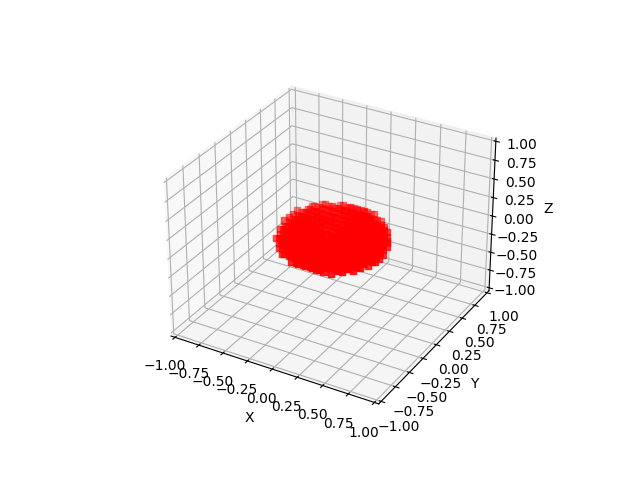

In [72]:
# Get the indices where is_fixed is equal to 1
indices = np.argwhere(is_fixed == 1)

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_set[indices[:, 0]], y_set[indices[:, 1]], z_set[indices[:, 2]], c='r', marker=',')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

plt.show()

## Solving the Discretized Laplace Equation
Now that we have set the problem geometry, we proceed to numreically solve for the Laplace equation $\nabla^2U=0$ using Jacobi method. 

In [73]:
def iterate(U_old):
    U_new = np.zeros([L, M, N])
    max_error = 0

    for i in range(1, L-1):
        for j in range(1, M-1):
            for k in range(1, N-1):
                if is_fixed[i][j][k] == 1:
                    continue
            
                U_new[i][j][k] = 1/6*(U_old[i-1][j][k] + U_old[i+1][j][k] + 
                                      U_old[i][j-1][k] + U_old[i][j+1][k] +
                                      U_old[i][j][k-1] + U_old[i][j][k+1])
                
                error = np.abs(U_new[i][j][k] - U_old[i][j][k])
                if error > max_error:
                    max_error = error
                
    return (U_new, max_error)

In [74]:
# Solve Laplace equation for electric potential
max_error = max_e + 1
while max_error > max_e:
    (U, max_error) = iterate(U)
    
Ex, Ey, Ez = np.gradient(-U, x_set, y_set, z_set)

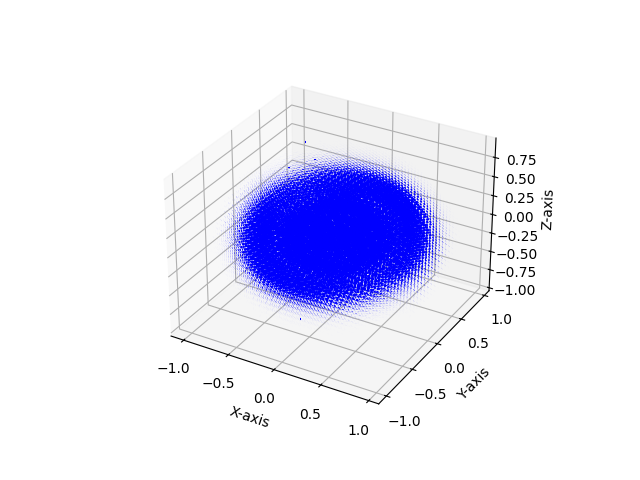

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_mesh, y_mesh, z_mesh = np.meshgrid(x_set, y_set, z_set)
ax.quiver(x_mesh, y_mesh, z_mesh, Ex, Ey, Ez, color='blue')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the plot
plt.show()

## Calculating $C$
Now that we have solved for $\vec{E}$, we wish to find the capacitance associated to the toroidal load. To this end we consider Gauss law for the electric field in the intregral form:
$$
\oiint_A \vec{E}\cdot\mathrm{d}\vec{A} = \frac{1}{\varepsilon_0\varepsilon_r}\iiint_V {\rho \, \mathrm{d}V} = \frac{Q}{\varepsilon_0\varepsilon_r},
$$
where $Q$ is the charge enclosed in the closed surface $A$. Therefore by calculating the flux through any surface containing the toroidal topload, we can compute the charge $Q$ stored in the load. This, together with the definition of capacitance $C = \frac{Q}{V}$ allows us to calculate $C$.

In [76]:
def calculate_flux(normal, Ex_m, Ey_m, Ez_m):
    Ex_v = Ex_m.flatten()
    Ey_v = Ey_m.flatten()
    Ez_v = Ez_m.flatten()
    dim = len(Ez_v)
    
    flux = 0
    
    for i in range(dim):
        E_vector = np.array([Ex_v[i], Ey_v[i], Ez_v[i]])
        flux = flux + np.dot(normal, E_vector)
    return flux

In [93]:
flux = 0

normal = np.array([-1, 0, 0])*h_step**2
Ex_slice = Ex[1,1:M-1,1:N-1]
Ey_slice = Ey[1,1:M-1,1:N-1]
Ez_slice = Ez[1,1:M-1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([+1, 0, 0])*h_step**2
Ex_slice = Ex[L-2,1:M-1,1:N-1]
Ey_slice = Ey[L-2,1:M-1,1:N-1]
Ez_slice = Ez[L-2,1:M-1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, -1, 0])*h_step**2
Ex_slice = Ex[1:L-1,1,1:N-1]
Ey_slice = Ey[1:L-1,1,1:N-1]
Ez_slice = Ez[1:L-1,1,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, +1, 0])*h_step**2
Ex_slice = Ex[1:L-1,M-2,1:N-1]
Ey_slice = Ey[1:L-1,M-2,1:N-1]
Ez_slice = Ez[1:L-1,M-2,1:N-1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, 0, +1])*h_step**2
Ex_slice = Ex[1:L-1,1:M-1,1]
Ey_slice = Ey[1:L-1,1:M-1,1]
Ez_slice = Ez[1:L-1,1:M-1,1]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

normal = np.array([0, 0, -1])*h_step**2
Ex_slice = Ex[1:L-1,1:M-1,N-2]
Ey_slice = Ey[1:L-1,1:M-1,N-2]
Ez_slice = Ez[1:L-1,1:M-1,N-2]
flux = flux + calculate_flux(normal, Ex_slice, Ey_slice, Ez_slice)

epsilon_0 = 8.8541878128e-12
Q = flux*epsilon_0

Q


1.1611728419785139e-13